In [1]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.utils import shuffle

df = pd.read_csv('../input/data/Data_Entry_2017.csv')

diseases = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
#Number diseases
for disease in diseases :
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

In [2]:
import os
labels = df[diseases].to_numpy()
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('..', 'input','data','images*','images','*.png'))}

print('Images found:', len(all_image_paths))

df['Path'] = df['Image Index'].map(all_image_paths.get)
files_list = df['Path'].tolist()

labelB = (df[diseases].sum(axis=1)>0).tolist()
labelB = np.array(labelB, dtype=int)

Images found: 112120


In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, shape):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=shape)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)/255
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, shape):
    list_of_tensors = [path_to_tensor(img_path, shape) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_labels = labelB[:89600][:, np.newaxis]
valid_labels = labelB[89600:100800][:, np.newaxis]
test_labels = labelB[100800:][:, np.newaxis]


img_shape = (64, 64)
train_tensors = paths_to_tensor(files_list[:89600], shape = img_shape)
valid_tensors = paths_to_tensor(files_list[89600:100800], shape = img_shape)
test_tensors = paths_to_tensor(files_list[100800:], shape = img_shape)

100%|██████████| 11320/11320 [04:58<00:00, 37.87it/s]


In [4]:
import time

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras import regularizers, applications, optimizers, initializers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=train_tensors.shape[1:])

add_model = Sequential()
add_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.2))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(50, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

# model.summary()

2022-12-01 02:04:21.021183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 02:04:21.172569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 02:04:21.173382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 02:04:21.174631: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 2s 0us/step


In [5]:
from keras import backend as K

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

In [6]:
import keras.backend as K
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True), 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy',
        precision_threshold(threshold = 0.5), 
        recall_threshold(threshold = 0.5), 
        fbeta_score_threshold(beta=0.5, threshold = 0.5)
    ]
)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import numpy as np

epochs = 5
batch_size = 32

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto')
log = CSVLogger('saved_models/log_pretrained_CNN.csv')
checkpointer = ModelCheckpoint(filepath='saved_models/pretrainedVGG.best.from_scratch.hdf5', verbose=1, save_best_only=True)

start = time.time()
train_datagen = ImageDataGenerator(
                        featurewise_center=False,  # set input mean to 0 over the dataset
                        samplewise_center=False,  # set each sample mean to 0
                        featurewise_std_normalization=False,  # divide inputs by std of the dataset
                        samplewise_std_normalization=False,  # divide each input by its std
                        zca_whitening=False,  # apply ZCA whitening
                        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                        horizontal_flip=True,  # randomly flip images
                        vertical_flip=False 
)



# Training with data augmentation. If shift_fraction=0., also no augmentation.
history = model.fit_generator(
    train_datagen.flow(train_tensors,train_labels, batch_size = batch_size),
    steps_per_epoch = len(train_tensors) // batch_size,
    validation_data = (valid_tensors, valid_labels),
    validation_steps = len(valid_tensors) // batch_size,
    epochs = epochs,
    callbacks=[checkpointer, log], verbose=1
)
print("training time: %.2f minutes"%((time.time()-start)/60))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-01 02:04:27.044396: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-12-01 02:04:35.710665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2799/2800 [============================>.] - ETA: 0s - loss: 0.7078 - accuracy: 0.5365 - precision: 0.4985 - recall: 0.4199 - fbeta_score: 0.4730

2022-12-01 02:07:51.962347: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 550502400 exceeds 10% of free system memory.
2022-12-01 02:07:52.270474: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 550502400 exceeds 10% of free system memory.


2800/2800 [==============================] - 210s 70ms/step - loss: 0.7078 - accuracy: 0.5365 - precision: 0.4986 - recall: 0.4199 - fbeta_score: 0.4730 - val_loss: 0.7061 - val_accuracy: 0.5405 - val_precision: 0.4014 - val_recall: 0.0911 - val_fbeta_score: 0.2078

Epoch 00001: val_loss improved from inf to 0.70611, saving model to saved_models/pretrainedVGG.best.from_scratch.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
2800/2800 [==============================] - 194s 69ms/step - loss: 0.6832 - accuracy: 0.5706 - precision: 0.5418 - recall: 0.4560 - fbeta_score: 0.5152 - val_loss: 0.6918 - val_accuracy: 0.5347 - val_precision: 0.3694 - val_recall: 0.0922 - val_fbeta_score: 0.1924

Epoch 00002: val_loss improved from 0.70611 to 0.69183, saving model to saved_models/pretrainedVGG.best.from_scratch.hdf5
Epoch 3/5
2800/2800 [==============================] - 192s 69ms/step - loss: 0.6714 - accuracy: 0.5922 - precision: 0.5682 - recall: 0.4827 - fbeta_score: 0.5424 - val_loss: 0.7471 - val_accuracy: 0.5446 - val_precision: 0.4573 - val_recall: 0.3341 - val_fbeta_score: 0.4068

Epoch 00003: val_loss did not improve from 0.69183
Epoch 4/5
2800/2800 [==============================] - 194s 69ms/step - loss: 0.6641 - accuracy: 0.6033 - precision: 0.5828 - recall: 0.5047 - fbeta_score: 0.5588 - val_loss: 0.7359 - val_accuracy: 0.5606 - val_precision: 0.3733 - val_recall: 0.0582 - val_fbeta_score: 0.16

In [8]:
prediction = model.predict(test_tensors)

2022-12-01 02:20:52.194481: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 556400640 exceeds 10% of free system memory.
2022-12-01 02:20:52.481138: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 556400640 exceeds 10% of free system memory.


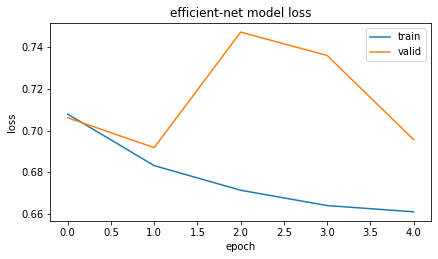

In [9]:
import matplotlib.pyplot as plt  

plt.figure(1, figsize = (15,8))  
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('efficient-net model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()


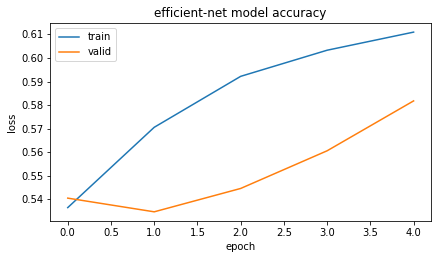

In [10]:
import matplotlib.pyplot as plt  

plt.figure(1, figsize = (15,8))  
    
plt.subplot(222)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('efficient-net model accuracy')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

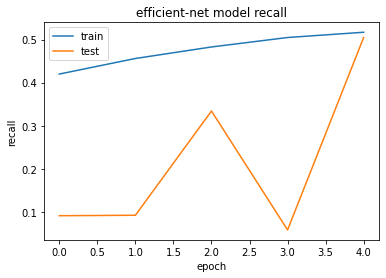

In [11]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

plt.title('efficient-net model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

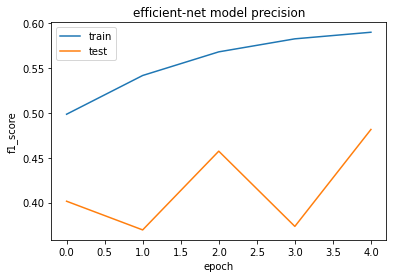

In [12]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])

plt.title('efficient-net model precision')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
threshold = 0.5
beta = 0.5

pre = K.eval(precision_threshold(threshold = threshold)(K.variable(value=test_labels),K.variable(value=prediction)))
rec = K.eval(recall_threshold(threshold = threshold)(K.variable(value=test_labels),K.variable(value=prediction)))
fsc = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value=test_labels),K.variable(value=prediction)))

print ("Precision: %f %%\nRecall: %f \nF1-score: %f"% (pre, rec, fsc))

Precision: 0.543384 %
Recall: 0.585560 
F1-score: 0.551326


In [14]:
K.eval(binary_accuracy(K.variable(value=test_labels), K.variable(value=prediction)))

0.5563604